# Using AutoEncoder as a Feature Extraction Tool

We have been using AE directly for the classifcation purposes, now we use it as a feature extraction tool.

Original post can be found [here](https://blog.myyellowroad.com/unsupervised-sentence-representation-with-deep-learning-104b90079a93).

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# from textblob import TextBlob
import numpy as np

In [2]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)

In [3]:
review_df = pd.read_csv('./amazon_data_20191202/processed.csv', index_col=0)
review_df.head()

,user_id,prod_id,date,text,review_id,rating,label
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,923020141208,3.0,-1
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,924020130516,3.0,-1
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,925020130701,4.0,-1
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,926020110728,4.0,-1
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,927020101101,4.0,-1


In [4]:
review_df.dtypes

user_id        int64
prod_id        int64
date          object
text          object
review_id      int64
rating       float64
label          int64
dtype: object

In [5]:
review_df['label'].unique()

array([-1,  1])

In [6]:
class_dict = {-1:0, 1:1}
review_df['label'] = review_df['label'].map(class_dict)
review_df['label'].unique()

array([0, 1])

In [7]:
sampled0 = review_df[review_df['label'] == 0].sample(n=10000, random_state=2019)
sampled1 = review_df[review_df['label' ]== 1].sample(n=10000, random_state=2019)
sampled = pd.concat([sampled0, sampled1])

In [8]:
sampled.shape

(20000, 7)

In [9]:
sampled.to_csv('./amazon_data_20191202/sampled20200104.csv')

## parse sentences

In [11]:
review_text = list(sampled['text'].values)
review_text[:1]

["At the moment Perilla is my favorite restaurant in this area. All their dishes are pretty solid. The duck meatballs is highly recommended. \xa0I don't know what my friend ordered in that night, but the server brought out this really strong rice liquor. \xa0Get it if you can... it will make your night."]

# preprocess for keras

In [12]:
#preprocess for keras
num_words=5000
maxlen=75

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [14]:
tokenizer = Tokenizer(num_words = num_words, split=' ')

tokenizer.fit_on_texts(review_text)
seqs = tokenizer.texts_to_sequences(review_text)
pad_seqs = []
for i in seqs:
    if len(i)>4:
        pad_seqs.append(i)
pad_seqs = pad_sequences(pad_seqs,maxlen)
pad_seqs[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          31,    1, 1259, 3250,    8,   17,  188,   62,   11,   15,  237,
          36,   54,  182,   29,  115,  615,    1,  384,  646,    8,  361,
         521,   79,   86,  153,   76,   17,  163,   85,   11,   14,  110,
          13,    1,  337,  522,   41,   15,   44,  858,  231, 1654, 2975,
           9,   40,   18,   73,    9,   75,  131,   77,  110],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    4,
          28,   80,  170,    5, 1274, 2890,   10,  113,  380,  359,    8,
          23,   39,    3,   87,  133,    8,    3,   87,   35,    8,   11,
          17, 1062,   91,  124,   87,  997,   11,    1,   71,    2,  262,
        1436,    1,  626,   49,    1,  178,  958,    7,  306,   30,  460,
           2,   14,    8,   83,  742,   35,   29,  197,   96,   24,  297,
          34,   24, 1009,   13, 1274, 2890,    8,

# The model

In [15]:
#The model
embed_dim = 512
latent_dim = 300
batch_size = 128

In [16]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, concatenate, GRU, RepeatVector
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.models import Model, load_model
#from keras.layers import Input, Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers, optimizers

In [17]:
#### Encoder Model ####
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False, trainable = True)
# Word embeding for encoder (ex: Issue Body)
x = emb_layer(encoder_inputs)
#state_h = GRU(latent_dim*2, name='Encoder-First-GRU', return_sequences=True)(x)
state_h = GRU(latent_dim, name='Encoder-Last-GRU')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
#### Decoder Model ####
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_gru = GRU(latent_dim, return_sequences=True, name='Decoder-GRU-before')
#decoder_gru = GRU(latent_dim*2, return_sequences=True, name='Decoder-GRU-second')
decoder_gru_output = decoder_gru(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_gru_output)

In [19]:
#### Seq2Seq Model ####
#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model(encoder_inputs,decoder_outputs )
seq2seq_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 75)                0         
_________________________________________________________________
Encoder-Model (Model)        (None, 300)               3291700   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 75, 300)           0         
_________________________________________________________________
Decoder-GRU-before (GRU)     (None, 75, 300)           540900    
_________________________________________________________________
Final-Output-Dense-before (D (None, 75, 5000)          1505000   
Total params: 5,337,600
Trainable params: 5,337,600
Non-trainable params: 0
_________________________________________________________________


In [20]:
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

In [21]:
checkpointer = ModelCheckpoint(filepath="seq2seq_model-0103.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [22]:
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          batch_size=batch_size,
          epochs=50,
          validation_split=0.10, 
          callbacks=[checkpointer, tensorboard, es]).history

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 17622 samples, validate on 1958 samples
Epoch 1/50
17622/17622 [==============================] - 29s 2ms/step - loss: 5.3985 - val_loss: 5.4966
Epoch 2/50
17622/17622 [==============================] - 29s 2ms/step - loss: 5.0342 - val_loss: 5.3906
Epoch 3/50
17622/17622 [==============================] - 28s 2ms/step - loss: 4.9691 - val_loss: 5.4078
Epoch 4/50
17622/17622 [==============================] - 28s 2ms/step - loss: 4.9635 - val_loss: 5.3916
Epoch 5/50
17622/17622 [==============================] - 28s 2ms/step - loss: 4.9386 - val_loss: 5.3492
Epoch 6/50
17622/17622 [==============================] - 28s 2ms/step - loss: 4.9210 - val_loss: 5.3843
Epoch 7/50
17622/17622 [==============================] - 28s 2ms/step - loss: 4.9086 - val_loss: 5.2979
Epoch 8/50
17622/17622 [==============================] - 28s 2ms/step - loss: 4.8759 - va

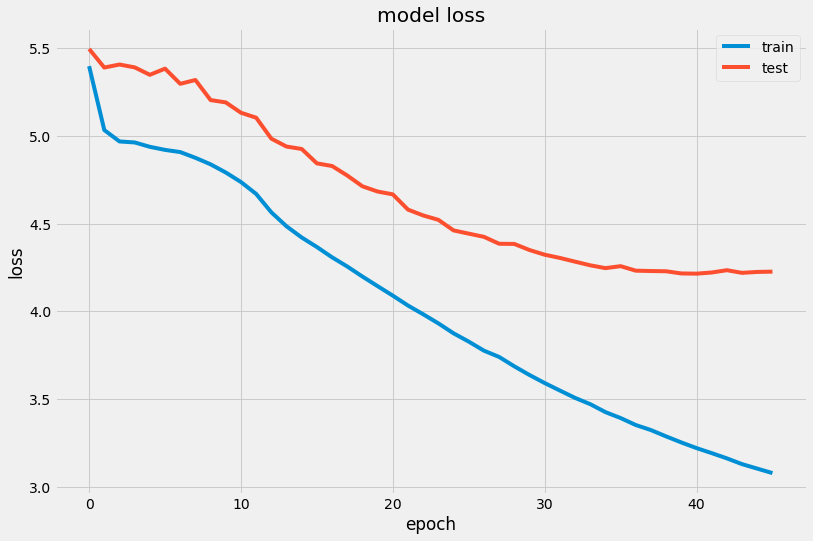

In [23]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

# Feature extraction

In [24]:
#Feature extraction
contents = tokenizer.texts_to_sequences(sampled['text'].values)
contents = pad_sequences(contents,maxlen=maxlen)

x = encoder_model.predict(contents)

In [25]:
np.random.seed(2019)

msk = np.random.rand(len(sampled)) < 0.9
msk

array([False,  True,  True, ...,  True,  True,  True])

In [26]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(sampled['label'].values)
y[:2]

array([0, 0])

In [27]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.63      0.64      0.63       984
          1       0.64      0.63      0.63      1000

avg / total       0.63      0.63      0.63      1984



In [30]:
lr.score(X_test, y_test)

0.6335685483870968

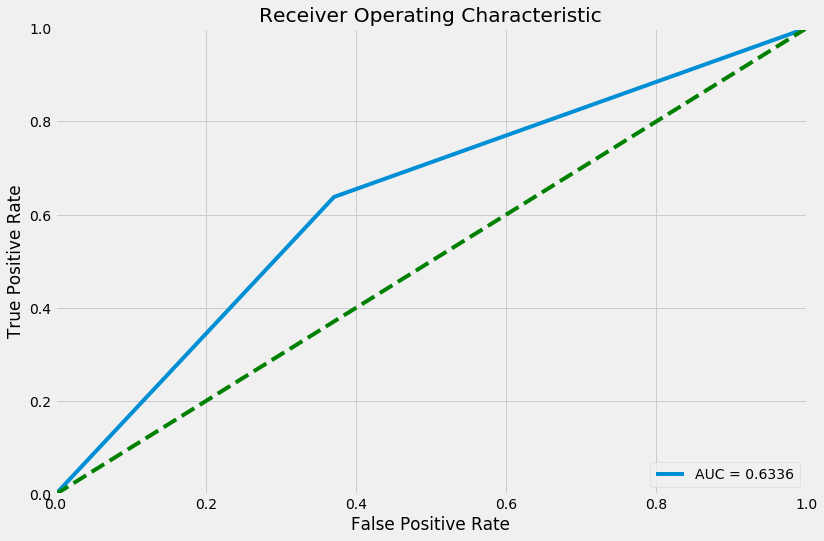

In [31]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

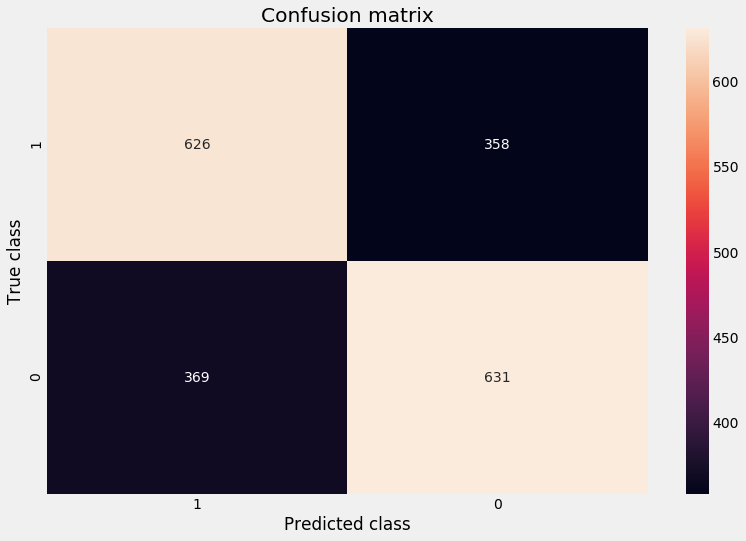

In [32]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [33]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.63      0.64      0.64       984
          1       0.64      0.64      0.64      1000

avg / total       0.64      0.64      0.64      1984



/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [34]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.71%


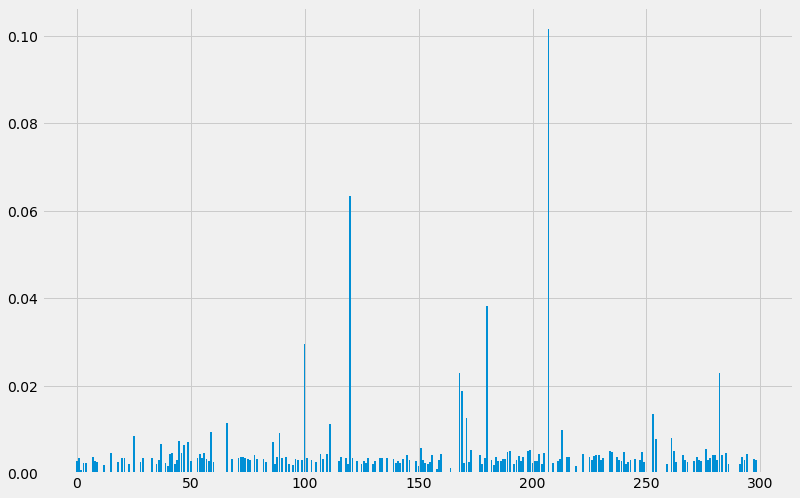

In [35]:
# print(model.feature_importances_)
# plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

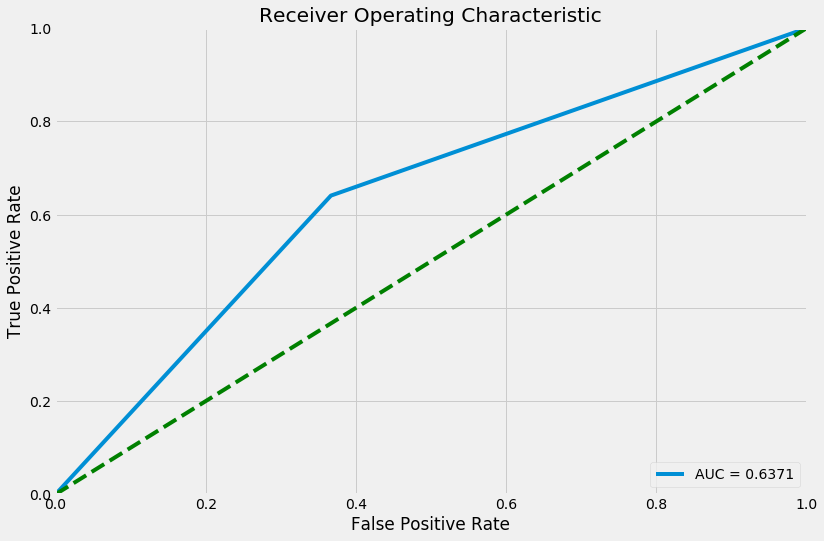

In [36]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

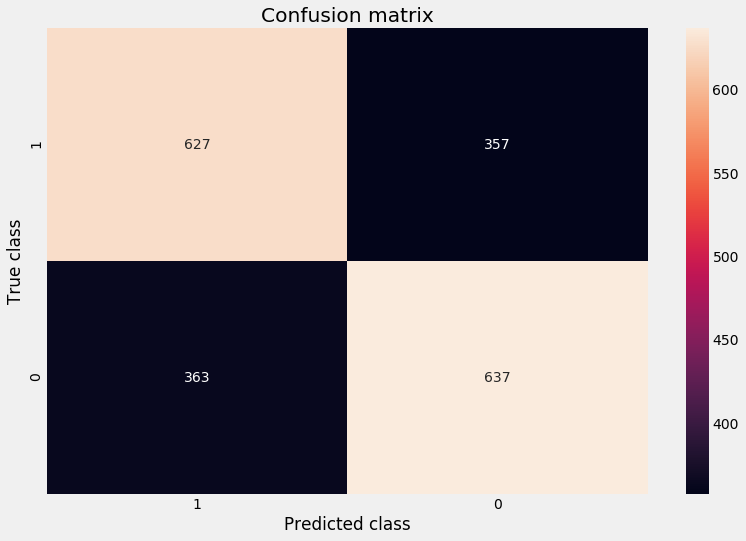

In [37]:
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Baseline Model

In [53]:
import gensim

In [54]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [55]:
x = np.random.rand(len(sampled), 300)
len(x)

20000

In [56]:


for i in range(len(sampled)):
    k = 0
    non = 0
    values = np.zeros(300)
    for j in sampled['text'].iloc[i].split(' '):
        if j in w2v:
            values+= w2v[j]
            k+=1
    if k > 0:
        x[i,:]=values/k
    else: 
        non+=1

In [57]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [58]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.63      0.57      0.60       984
          1       0.61      0.67      0.64      1000

avg / total       0.62      0.62      0.62      1984



In [59]:
lr.score(X_test,y_test)

0.6194556451612904

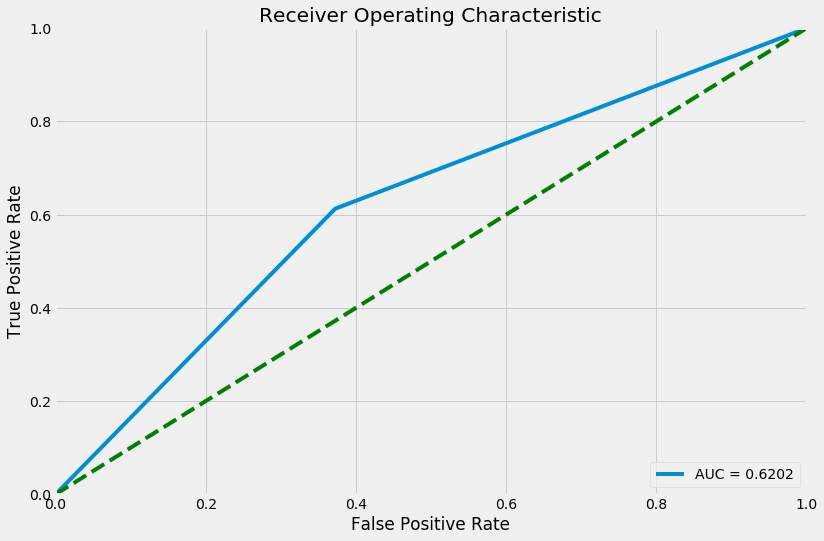

In [60]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

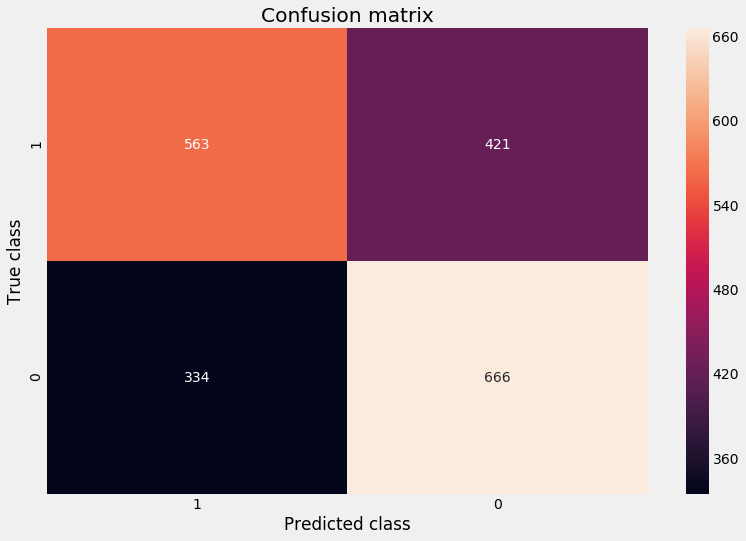

In [61]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [62]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [63]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [64]:
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.65      0.62      0.63       984
          1       0.64      0.67      0.66      1000

avg / total       0.65      0.65      0.64      1984



In [65]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.52%


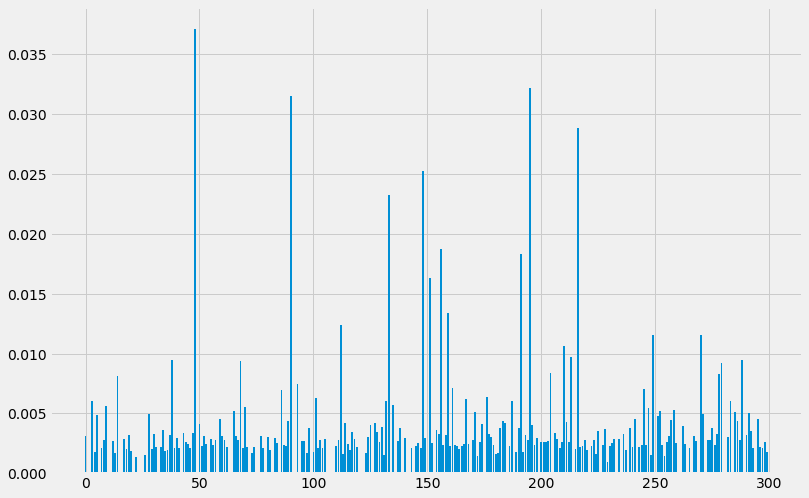

In [66]:
# print(model.feature_importances_)
# plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

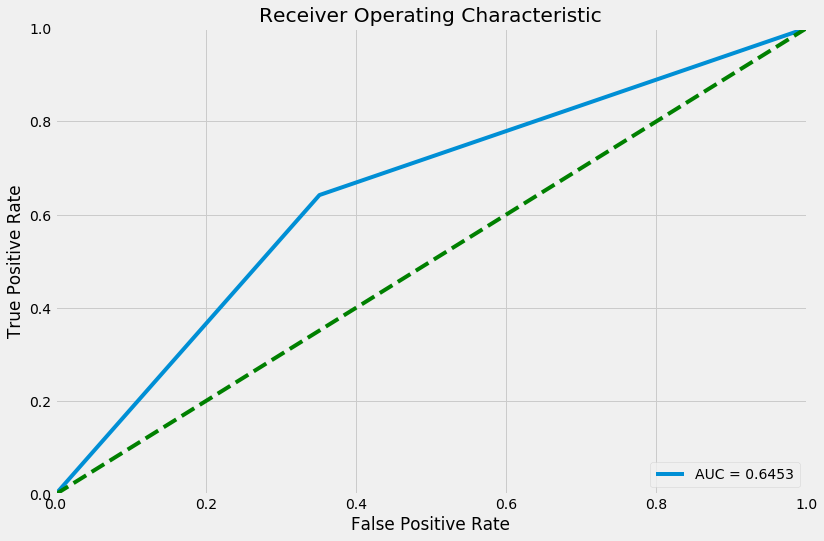

In [67]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

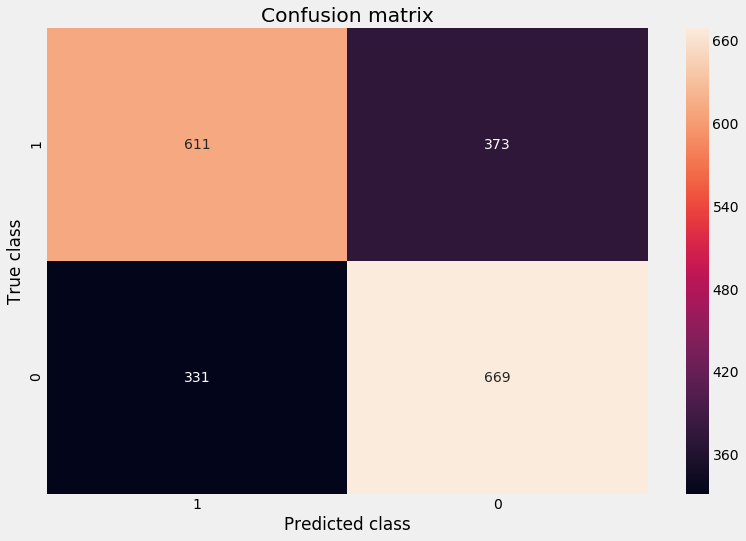

In [68]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Skip-Thought Vectors

In [69]:
#Build x and y
num_words=5000
maxlen=75
tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(review_text)
seqs = tokenizer.texts_to_sequences(review_text)
pad_seqs = pad_sequences(seqs,maxlen)
x_skip = []
y_before = []
y_after = []

In [70]:
for i in range(1,len(seqs)-1):
    if len(seqs[i])>4:
        x_skip.append(pad_seqs[i].tolist())
        y_before.append(pad_seqs[i-1].tolist())
        y_after.append(pad_seqs[i+1].tolist())

In [71]:
x_before = np.matrix([[0]+i[:-1] for i in y_before])
x_after =np.matrix([[0]+i[:-1] for i in y_after])
x_skip = np.matrix(x_skip)
y_before = np.matrix(y_before)
y_after = np.matrix(y_after)

In [72]:
#Building the model

embed_dim = 128
latent_dim = 64
batch_size = 128

In [73]:
#### Encoder Model ####
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [74]:
#### Decoder Model ####
decoder_inputs_before = Input(shape=(None,), name='Decoder-Input-before')  # for teacher forcing
dec_emb_before = emb_layer(decoder_inputs_before)
decoder_gru_before = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU-before')
decoder_gru_output_before, _ = decoder_gru_before(dec_emb_before, initial_state=seq2seq_encoder_out)
decoder_dense_before = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs_before = decoder_dense_before(decoder_gru_output_before)
decoder_inputs_after = Input(shape=(None,), name='Decoder-Input-after')  # for teacher forcing
dec_emb_after = emb_layer(decoder_inputs_after)
decoder_gru_after = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU-after')
decoder_gru_output_after, _ = decoder_gru_after(dec_emb_after, initial_state=seq2seq_encoder_out)
decoder_dense_after = Dense(num_words, activation='softmax', name='Final-Output-Dense-after')
decoder_outputs_after = decoder_dense_after(decoder_gru_output_after)

In [75]:
#### Seq2Seq Model ####
seq2seq_Model = Model([encoder_inputs, decoder_inputs_before,decoder_inputs_after], [decoder_outputs_before,decoder_outputs_after])
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
seq2seq_Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input-before (InputLaye (None, None)         0                                            
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 75)           0                                            
__________________________________________________________________________________________________
Decoder-Input-after (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
Body-Word-Embedding (Embedding) (None, 75, 128)      640000      Decoder-Input-before[0][0]       
                                                                 Decoder-Input-after[0][0]        
__________

In [76]:
history = seq2seq_Model.fit([x_skip,x_before, x_after], [np.expand_dims(y_before, -1),np.expand_dims(y_after, -1)],
          batch_size=batch_size,
          epochs=50,
          validation_split=0.10,
          callbacks=[checkpointer, tensorboard, es]).history

Train on 17620 samples, validate on 1958 samples
Epoch 1/50
17620/17620 [==============================] - 45s 3ms/step - loss: 11.4689 - Final-Output-Dense-before_loss: 5.7343 - Final-Output-Dense-after_loss: 5.7346 - val_loss: 11.1983 - val_Final-Output-Dense-before_loss: 5.5876 - val_Final-Output-Dense-after_loss: 5.6107
Epoch 2/50
17620/17620 [==============================] - 44s 2ms/step - loss: 9.6467 - Final-Output-Dense-before_loss: 4.7998 - Final-Output-Dense-after_loss: 4.8469 - val_loss: 10.2108 - val_Final-Output-Dense-before_loss: 5.0981 - val_Final-Output-Dense-after_loss: 5.1128
Epoch 3/50
17620/17620 [==============================] - 43s 2ms/step - loss: 9.0187 - Final-Output-Dense-before_loss: 4.5103 - Final-Output-Dense-after_loss: 4.5084 - val_loss: 9.8826 - val_Final-Output-Dense-before_loss: 4.9430 - val_Final-Output-Dense-after_loss: 4.9396
Epoch 4/50
17620/17620 [==============================] - 43s 2ms/step - loss: 8.7244 - Final-Output-Dense-before_loss: 4.3

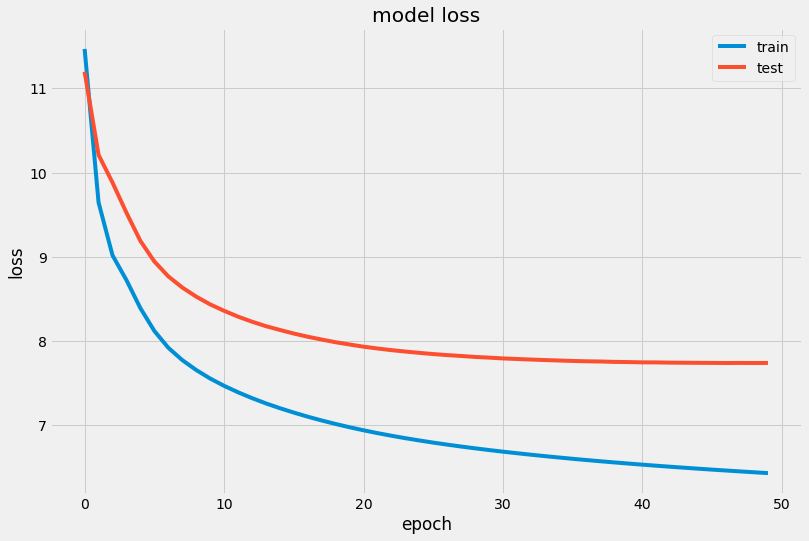

In [77]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [78]:
#Feature extraction
contents = tokenizer.texts_to_sequences(sampled['text'].values)
contents = pad_sequences(contents,maxlen=maxlen)

x = encoder_model.predict(contents)

In [79]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [80]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.61      0.63      0.62       984
          1       0.62      0.60      0.61      1000

avg / total       0.62      0.62      0.62      1984



In [81]:
lr.score(X_test,y_test)

0.6154233870967742

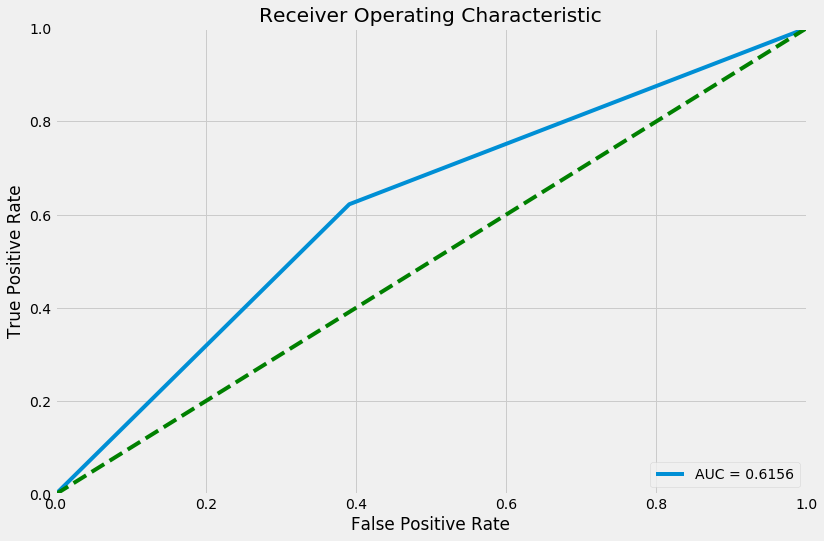

In [82]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

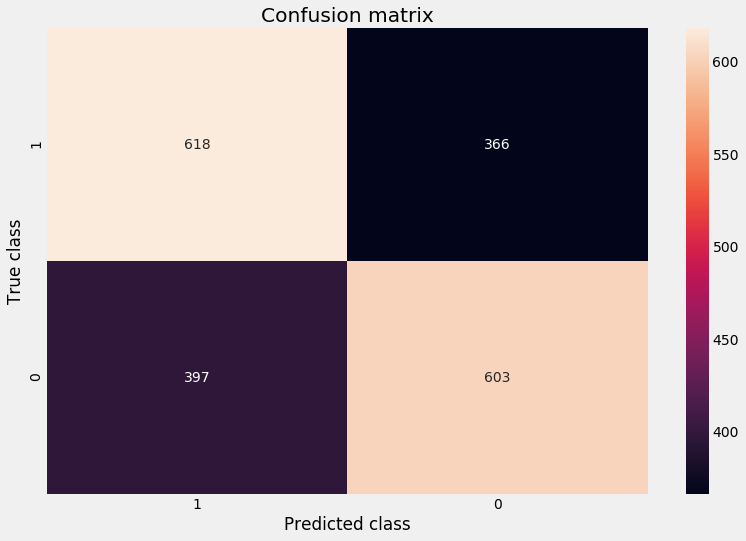

In [83]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [84]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.61      0.58      0.59       984
          1       0.60      0.63      0.62      1000

avg / total       0.61      0.61      0.61      1984



/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [85]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.58%


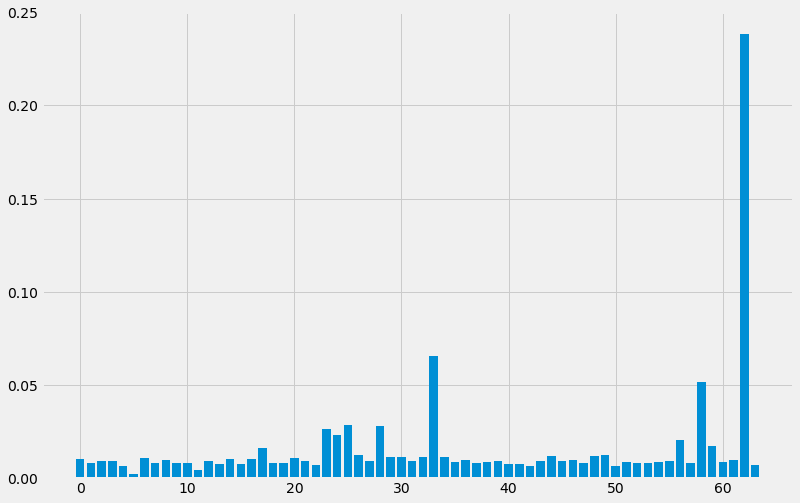

In [86]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

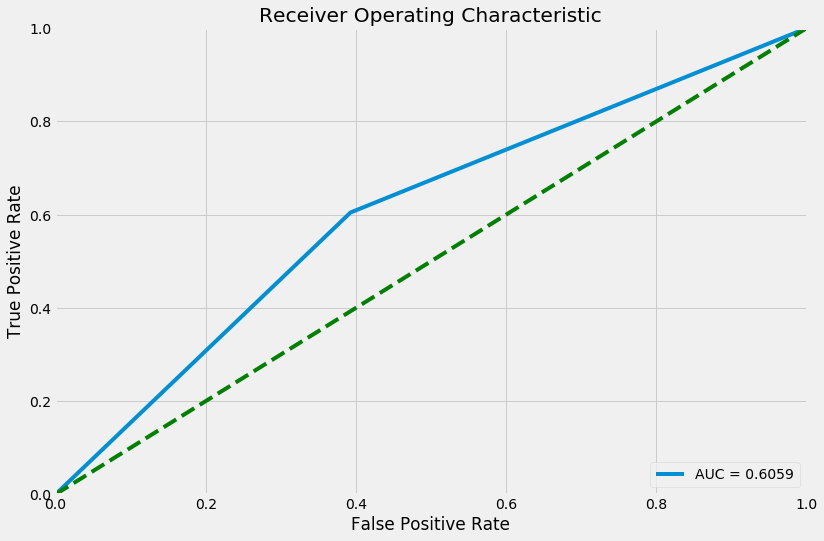

In [87]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

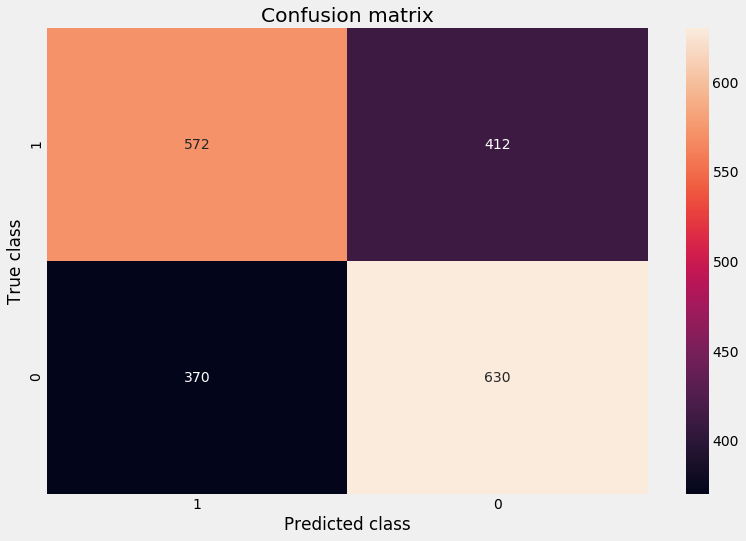

In [88]:
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()